<a href="https://colab.research.google.com/github/imdeepmind/UdacitySelfDrivingCar/blob/master/Base_Model_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Getting the into colab
!git clone https://github.com/imdeepmind/UdacitySelfDrivingCar.git
!mkdir data
!mv UdacitySelfDrivingCar/* ./
!rm -r UdacitySelfDrivingCar

Cloning into 'UdacitySelfDrivingCar'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 5257 (delta 2), reused 0 (delta 0), pack-reused 5251
Receiving objects: 100% (5257/5257), 148.81 MiB | 24.38 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [3]:
!pip install neuralpy-torch

     |████████████████████████████████| 81kB 5.5MB/s 


In [29]:
# Dependencies
import pandas as pd
import numpy as np
import cv2

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, sampler
import torchvision.transforms as transforms

from neuralpy.models import Sequential
from neuralpy.layers import Conv2D, Dense, Flatten, MaxPool2D
from neuralpy.regularizers import Dropout2D
from neuralpy.activation_functions import ReLU

In [5]:
# Constants
CSV_FILE = './data/driver_log_cleaned.csv'
BATCH_SIZE=32
EPOCH=10

In [6]:
# Reading CSV file
data = pd.read_csv(CSV_FILE)
data.head()

,center_camera,left_camera,right_camera,steering,throttle,reverse,speed
0,./data/IMG/center_2020_09_05_16_40_17_113.jpg,./data/IMG/left_2020_09_05_16_40_17_113.jpg,./data/IMG/right_2020_09_05_16_40_17_113.jpg,0.0,0.0,0,0.000077
1,./data/IMG/center_2020_09_05_16_40_17_214.jpg,./data/IMG/left_2020_09_05_16_40_17_214.jpg,./data/IMG/right_2020_09_05_16_40_17_214.jpg,0.0,0.0,0,0.000077
2,./data/IMG/center_2020_09_05_16_40_17_320.jpg,./data/IMG/left_2020_09_05_16_40_17_320.jpg,./data/IMG/right_2020_09_05_16_40_17_320.jpg,0.0,0.0,0,0.000077
3,./data/IMG/center_2020_09_05_16_40_17_425.jpg,./data/IMG/left_2020_09_05_16_40_17_425.jpg,./data/IMG/right_2020_09_05_16_40_17_425.jpg,0.0,0.0,0,0.000077
4,./data/IMG/center_2020_09_05_16_40_17_531.jpg,./data/IMG/left_2020_09_05_16_40_17_531.jpg,./data/IMG/right_2020_09_05_16_40_17_531.jpg,0.0,0.0,0,0.000077


In [7]:
center_image = data["center_camera"].values

steering = data["steering"].values

In [8]:
# Custom Data Loader class
class DriveDataset(Dataset):
  def __init__(self, center_images, steering, transform=None):
    self.__center_images = center_images

    self.__steering = steering

    self.__transform = transform
  
  def __len__(self):
    return len(self.__steering)
  
  def __getitem__(self, index):
    center = cv2.imread(self.__center_images[index], 1)

    if self.__transform:
      center = self.__transform(center)

    steering = torch.tensor(float(self.__steering[index]))

    return center, steering

In [9]:
# Making the data loader generator
dataset = DriveDataset(center_image, steering, transform=transforms.ToTensor())
train_set, test_set = torch.utils.data.random_split(dataset, [int(len(center_image) * .8), int(len(steering) - (len(steering) * .8) + 1) ])

train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=3, input_shape=(3, 160,320)))
model.add(ReLU())
model.add(MaxPool2D(kernel_size=2))
model.add(Dropout2D())

model.add(Conv2D(filters=64, kernel_size=3))
model.add(ReLU())
model.add(MaxPool2D(kernel_size=2))
model.add(Dropout2D())

model.add(Conv2D(filters=128, kernel_size=3))
model.add(ReLU())
model.add(MaxPool2D(kernel_size=2))
model.add(Dropout2D())

model.add(Conv2D(filters=128, kernel_size=3))
model.add(ReLU())
model.add(MaxPool2D(kernel_size=2))
model.add(Dropout2D())

model.add(Conv2D(filters=256, kernel_size=3))
model.add(ReLU())
model.add(MaxPool2D(kernel_size=2))
model.add(Dropout2D())

model.add(Conv2D(filters=256, kernel_size=3))
model.add(ReLU())
model.add(Dropout2D())

model.add(Flatten())

model.add(Dense(1024))
model.add(ReLU())

model.add(Dense(1024))
model.add(ReLU())

model.add(Dense(1))

In [11]:
model.build()
model.summary()

The model is running on cuda:0
Sequential(
  (conv2d_layer_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu_layer_2): ReLU()
  (maxpool2d_layer_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2d_layer_4): Dropout2d(p=0.5, inplace=False)
  (conv2d_layer_5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu_layer_6): ReLU()
  (maxpool2d_layer_7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2d_layer_8): Dropout2d(p=0.5, inplace=False)
  (conv2d_layer_9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (relu_layer_10): ReLU()
  (maxpool2d_layer_11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2d_layer_12): Dropout2d(p=0.5, inplace=False)
  (conv2d_layer_13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (relu_layer_14): ReLU()
  (maxpool2d_layer_15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2d

In [24]:
pytorch_model = model.get_model()
pytorch_model

Sequential(
  (conv2d_layer_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu_layer_2): ReLU()
  (maxpool2d_layer_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2d_layer_4): Dropout2d(p=0.5, inplace=False)
  (conv2d_layer_5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu_layer_6): ReLU()
  (maxpool2d_layer_7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2d_layer_8): Dropout2d(p=0.5, inplace=False)
  (conv2d_layer_9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (relu_layer_10): ReLU()
  (maxpool2d_layer_11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2d_layer_12): Dropout2d(p=0.5, inplace=False)
  (conv2d_layer_13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (relu_layer_14): ReLU()
  (maxpool2d_layer_15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2d_layer_16): Dropout2d(p=0.5, in

In [25]:
# Pytorch devoce
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [26]:
# Optimizer and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(pytorch_model.parameters(), lr=0.001)

In [27]:
training_losses = []
validation_losses = []

for epoch in range(EPOCH):
  dataiter = iter(train_loader)

  pytorch_model.train()

  for i, data in enumerate(dataiter):
    # unpacking the data
    images, labels = data
    
    # moving the data to device
    images = images.to(device)
    labels = labels.to(device)

    # passing the image through the model and predict something
    out = pytorch_model(images)

    # calculating the loss based on the prediction
    loss = criterion(out, labels.view(-1, 1))

    # apending the loss
    training_losses.append(loss.item())
    
    # zero gradient
    optimizer.zero_grad()

    # backpropagation
    loss.backward()
    
    # update the parameters
    optimizer.step()

    # printing a message
    if (i+1) % 10 == 0:
      print(f"Epoch: {epoch+1}:{EPOCH}  Batch: {i+1}  Training Loss: {loss.item()*10000}")
  
  test_data = iter(test_loader)

  pytorch_model.eval()

  with torch.no_grad():
    for i, data in enumerate(test_data):
      # unpacking the data
      images, labels = data
      
      # moving the data to device
      images = images.to(device)
      labels = labels.to(device)

      # passing the image through the model and predict something
      out = pytorch_model(images)

      # calculating the loss based on the prediction
      loss = criterion(out, labels.view(-1, 1))

      # apending the loss
      validation_losses.append(loss.item())

      # printing a message
      if (i+1) % 10 == 0:
        print(f"Epoch: {epoch+1}:{EPOCH}  Batch: {i+1}  Validation Loss: {loss.item()*10000}")

Epoch: 1:10  Batch: 10  Training Loss: 136.50438748300076
Epoch: 1:10  Batch: 20  Training Loss: 223.6170507967472
Epoch: 1:10  Batch: 30  Training Loss: 256.18063285946846
Epoch: 1:10  Batch: 40  Training Loss: 292.8575128316879
Epoch: 1:10  Batch: 10  Validation Loss: 470.8047956228256
Epoch: 2:10  Batch: 10  Training Loss: 55.70923909544945
Epoch: 2:10  Batch: 20  Training Loss: 248.50627407431602
Epoch: 2:10  Batch: 30  Training Loss: 405.64022958278656
Epoch: 2:10  Batch: 40  Training Loss: 151.68831683695316
Epoch: 2:10  Batch: 10  Validation Loss: 377.75833159685135
Epoch: 3:10  Batch: 10  Training Loss: 186.58433109521866
Epoch: 3:10  Batch: 20  Training Loss: 444.7556659579277
Epoch: 3:10  Batch: 30  Training Loss: 739.9865239858627
Epoch: 3:10  Batch: 40  Training Loss: 87.79005147516727
Epoch: 3:10  Batch: 10  Validation Loss: 430.5070638656616
Epoch: 4:10  Batch: 10  Training Loss: 172.3254844546318
Epoch: 4:10  Batch: 20  Training Loss: 23.339930921792984
Epoch: 4:10  Batc

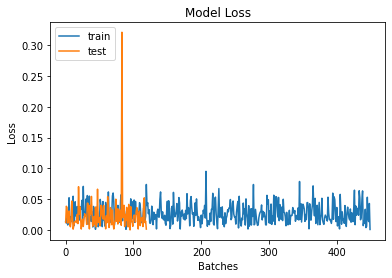

In [30]:
plt.plot(training_losses)
plt.plot(validation_losses)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Batches')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
torch.save(pytorch_model.state_dict(), './model.pth')